In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Először is kell egy loop a fájlok beolvasására; ezeket mind el kell majd tárolni, szóval lehet először egy beolvasóciklus egy adott könyvtár összes fájljára, majd ezekre egyesével lefuttatom majd a normálást, a rebint, majd a főkompinens analízist. Tehát beolvasás:

In [4]:
import os
from numpy import loadtxt
from numpy import append
import codecs

In [3]:
indir = './SDSS/Spectra'
spektra={}
for root, dirs, filenames in os.walk(indir):
    i=0
    for f in filenames:
        filecp = codecs.open(os.path.join(root, f), encoding = 'cp1252')
        content = loadtxt(filecp, comments="#", delimiter="\t", unpack=False)
        array=content[:,[0, 7]]
        spektra[i]=array
        i+=1
        del content
        del array
  #  print(spektra)

In [3]:
# Save
# numpy.save('./PCAfeldolgozas/spektrumok.npy', spektra) 

# Load
spektra = numpy.load('./PCAfeldolgozas/spektrumok.npy').item()
# print(read_dictionary)

In [4]:
del spektra
#read_dictionary = numpy.load('./PCAfeldolgozas/spektrumok.npy').item()
#spektra=read_dictionary

In [12]:
spektra = numpy.load('./PCAfeldolgozas/spektrumok.npy').item()
n=0
spektranew={}
for i in range (0,13787):
    temp=spektra[i]
    if(max(temp[:,0])>8630):
        spektranew[n]=temp
        n+=1
print(n)

4950


**TÖBB HELYEN IS ÁT LETT ÍRVA A SPEKTRA SPEKTRANEW-RA, MIVEL AZ UTÓBBIBAN VANNAK AZOK AMIKET A KÉSŐBBI VIZSGÁLATOKHOZ FEL TUDOK MAJD HASZNÁLNI**

In [20]:
spektra=spektranew

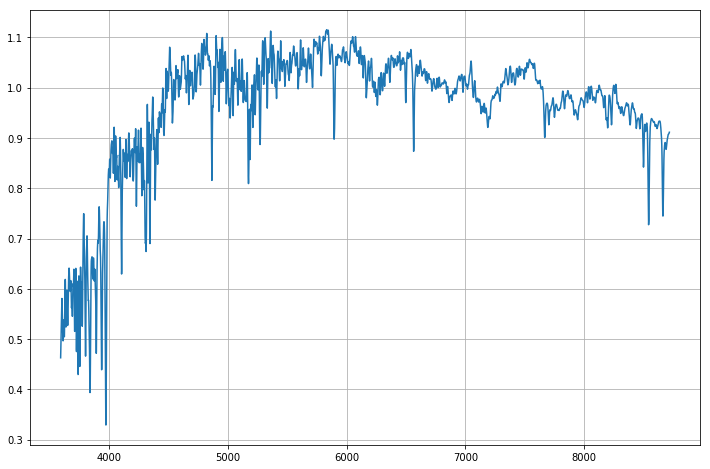

In [15]:
figsize(12,8)
temp=spektra[0]
plot(temp[:,0],temp[:,1])
grid(True)
del temp

Tehát most az egyes spektrumok benne vannak a **spektra** dictionaryban, viszont se lenormálva, se rebinnelve nincsenek. A normáláshoz először ki kell szedni azon értékeket melyek abban részt vesznek ($\lambda$ a következő tartományok egyikében van: $4250-4300$, $4600-4800$, $5400-5500$ vagy $5600-5800$). Ezekre a tartományokra vesszük a mediánt, majd azokat átlagoljuk és leosztjuk vele az egész spektrumot.

In [18]:
i=n

In [21]:
for j in range (0,i):
    temp=spektra[j]
    m1=0
    m2=0
    m3=0
    m4=0
    n=0
    for k in temp[:,0]:
        if(k>4250 and k<4300):
            if(m1==0):
                normalashoz1=temp[n,1]
                m1+=1
            else:
                normalashoz1=numpy.append(normalashoz1,temp[n,1])
                
        if(k>4600 and k<4800):
            if(m2==0):
                normalashoz2=temp[n,1]
                m2+=1
            else:
                normalashoz2=numpy.append(normalashoz2,temp[n,1])
                
        if(k>5400 and k<5500):
            if(m3==0):
                normalashoz3=temp[n,1]
                m3+=1
            else:
                normalashoz3=numpy.append(normalashoz3,temp[n,1])
                
        if(k>5600 and k<5800):
            if(m4==0):
                normalashoz4=temp[n,1]
                m4+=1
            else:
                normalashoz4=numpy.append(normalashoz4,temp[n,1])
                
        n+=1
        
    med1=numpy.median(normalashoz1)
    med2=numpy.median(normalashoz2)
    med3=numpy.median(normalashoz3)
    med4=numpy.median(normalashoz4)
    avgmed=(med1+med2+med3+med4)/4
        
    temp[:,1]=temp[:,1]/avgmed
    spektra[j]=temp
    del temp

In [24]:
print(spektra)

{0: array([[  3.58880495e+03,   4.63870120e-01],
       [  3.58963140e+03,   4.73470960e-01],
       [  3.59045803e+03,   4.85328351e-01],
       ..., 
       [  8.71464810e+03,   9.10664552e-01],
       [  8.71665495e+03,   9.11927464e-01],
       [  8.71866227e+03,   9.13566797e-01]]), 1: array([[  3.59110662e+03,   6.44987967e-01],
       [  3.59193360e+03,   6.59317821e-01],
       [  3.59276077e+03,   6.62845562e-01],
       ..., 
       [  8.72023723e+03,   7.90820825e-01],
       [  8.72224537e+03,   7.94041441e-01],
       [  8.72425397e+03,   7.98164081e-01]]), 2: array([[  3.66969812e+03,   6.90609350e-01],
       [  3.67054320e+03,   6.89623701e-01],
       [  3.67138847e+03,   6.97046130e-01],
       ..., 
       [  8.91107994e+03,   7.83947348e-01],
       [  8.91313203e+03,   7.73125273e-01],
       [  8.91518459e+03,   7.73362378e-01]]), 3: array([[  3.61700416e+03,   6.99811849e-01],
       [  3.61783710e+03,   6.95892823e-01],
       [  3.61867023e+03,   6.92913957e-01

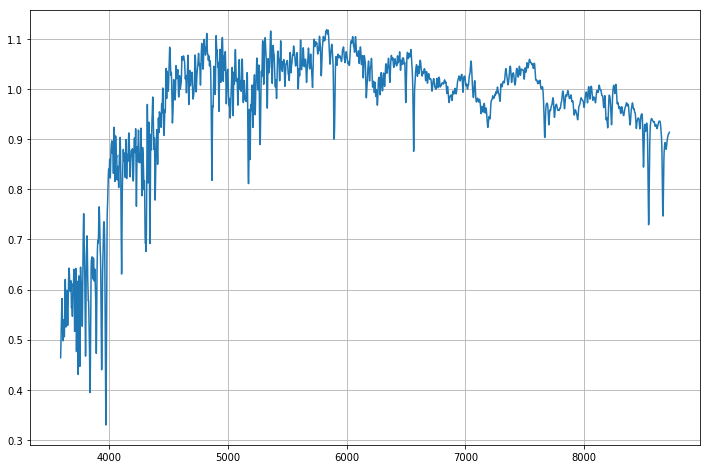

In [22]:
temp=spektra[0]
plot(temp[:,0],temp[:,1])
grid(True)
del temp

A normálás már megvan, most rebinnelem a spektrumokat

In [23]:
def interpol(x1,x2,y1,y2,xk):
    a=(y2-y1)/(x2-x1)
    b=y1-x1*(y2-y1)/(x2-x1)
    
    yx=a*xk+b
    
    return(yx)

In [5]:
mintapontok=linspace(3724,6760.6,5062)
nullak=linspace(0,0,5062)

A **temp**-be olvasom be az egyes normált spektrumokat, majd ezekre végzem a rebinnelést: a kívánt rácspontokat veszem egyesével, majd megnézem, melyik két mérési pont közé esik, és az ottani mérési értékekből interpolálok oda egy értéket. Ezt megteszem a teljes spektrumra. Itt a **v** az újramintavételezett spektrum indexein fut, **w** pedig a normált spektrumén.

In [9]:
umspektra={}
for j in range (0,i):
    umspektrum=numpy.vstack((mintapontok,nullak)).T
    temp=spektra[j]
    v=0
    w=0
    for q in range (0,5062):
        xk=mintapontok[q]
        while(temp[w,0]<6760.6):
            if(xk>temp[w,0] and xk<temp[w+1,0]):
                yk=interpol(temp[w,0],temp[w+1,0],temp[w,1],temp[w+1,1],xk)
                umspektrum[v,0]=xk
                umspektrum[v,1]=yk
                v+=1
                break
            w+=1
    del temp
    umspektra[j]=umspektrum
    del umspektrum
del spektra

In [10]:
numpy.save('./PCAfeldolgozas/ujramint_spektrumok.npy', umspektra) 

In [32]:
umspektra=numpy.load('./PCAfeldolgozas/ujramint_spektrumok.npy').item()

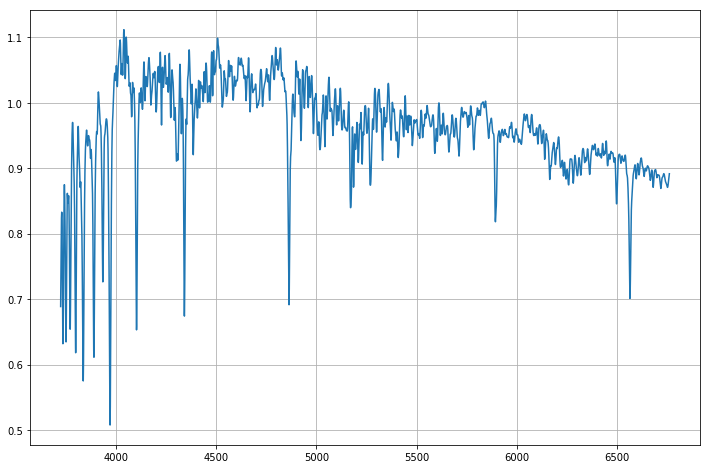

In [33]:
temp=umspektra[0]
plot(temp[:,0],temp[:,1])
grid(True)
del temp

Eddig a lépésig többször ellenőrizve, egyezést ad a C-ben írt programomból kapott adatsorral.

Most ki kell számolni az átlagspektrumot, melyet le kell majd vonni a PCA előtt.

In [34]:
atlagspektrum=numpy.vstack((mintapontok,nullak)).T
for k in range (0,5062):
    for j in range (0,i):
        temp=umspektra[j]
        atlagspektrum[k,1]+=temp[k,1]
        del temp
    atlagspektrum[k,1]=atlagspektrum[k,1]/(i)
numpy.save('./PCAfeldolgozas/atlagspektrum.npy', atlagspektrum)
# print(atlagspektrum)

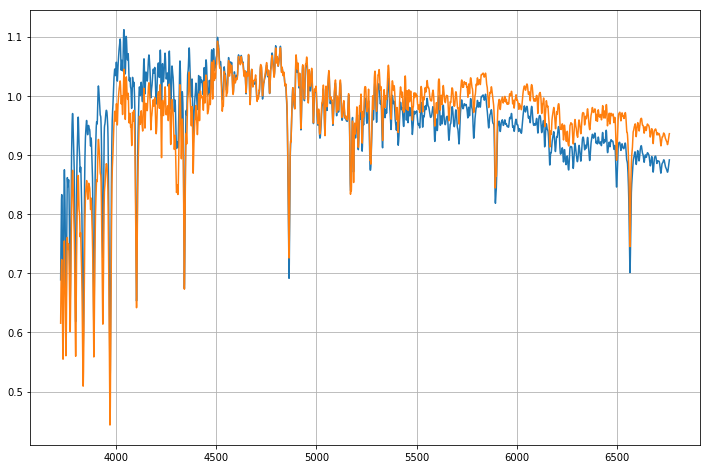

In [13]:
figsize(12,8)
temp=umspektra[0]
plot(temp[:,0],temp[:,1],atlagspektrum[:,0],atlagspektrum[:,1])
grid(True)
del temp

In [14]:
red_umspektra={}
for j in range (0,i):
    temp=umspektra[j]
    for k in range (0,5062):
        temp[k,1]=temp[k,1]-atlagspektrum[k,1]
    red_umspektra[j]=temp
    del temp
del umspektra
# print(red_umspektra)

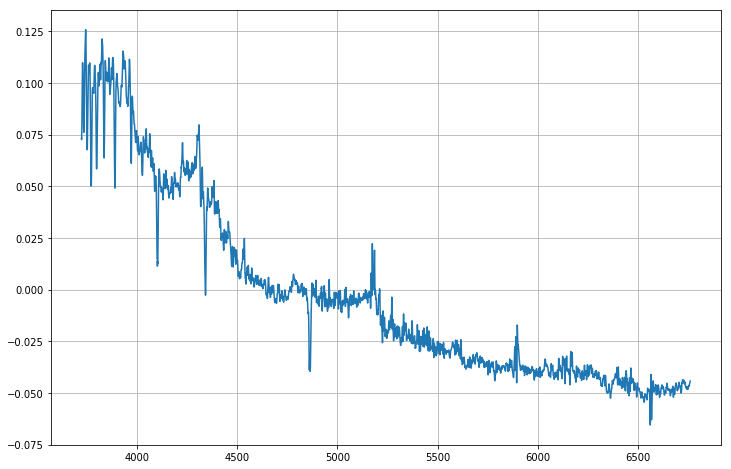

In [15]:
temp=red_umspektra[0]
plot(temp[:,0],temp[:,1])
grid(True)
del temp

Először létrehozom a korrelációmátrixot

In [17]:
korrelaciomatrix=numpy.tile(nullak,(i,1))
korrelaciomatrix=korrelaciomatrix.T
for j in range (0,i):
    temp=red_umspektra[j]
    korrelaciomatrix[:,j]=temp[:,1]
    del temp
# print(korrelaciomatrix)
numpy.save('./PCAfeldolgozas/KorrMTX.npy',korrelaciomatrix)

In [18]:
xxT=numpy.dot(korrelaciomatrix, korrelaciomatrix.T)
# print(xxT)

Majd erre futtatom le az SVD-t

In [20]:
U, s, V = numpy.linalg.svd(xxT)
U.shape, V.shape, s.shape
numpy.save('./PCAfeldolgozas/Vmtx.npy',V)
numpy.save('./Pcafeldolgozas/SingVal.npy',s)

In [47]:
 print(V)

[[ -1.91938097e-02  -1.95828915e-02  -2.01600426e-02 ...,   1.69453012e-02
    1.69846303e-02   1.70361644e-02]
 [ -4.26701482e-02  -4.00590409e-02  -3.66875986e-02 ...,  -1.93599142e-02
   -1.91596533e-02  -1.92605230e-02]
 [ -6.21643698e-02  -5.02819633e-02  -3.72515261e-02 ...,   1.17404292e-02
    1.17857773e-02   1.17057251e-02]
 ..., 
 [  0.00000000e+00  -2.50211508e-03   9.30925627e-03 ...,   3.34951601e-04
    5.46158741e-03  -2.69110510e-03]
 [  0.00000000e+00   1.20527876e-01  -9.29965858e-02 ...,  -3.83028610e-03
    6.11904583e-04  -2.70542585e-03]
 [ -9.93843523e-01   1.13762389e-02   8.72342508e-03 ...,  -1.38786854e-03
   -5.64241039e-04  -9.68388621e-04]]


In [55]:
print(U)

[[ -1.91938097e-02  -4.26701482e-02  -6.21643698e-02 ...,  -2.20148540e-04
    1.08677088e-01   6.33913553e-01]
 [ -1.95828915e-02  -4.00590409e-02  -5.02819633e-02 ...,  -1.90650960e-03
   -1.30390999e-02   2.30554891e-03]
 [ -2.01600426e-02  -3.66875986e-02  -3.72515261e-02 ...,   8.90231042e-03
   -4.08659716e-02  -1.63572905e-02]
 ..., 
 [  1.69453012e-02  -1.93599142e-02   1.17404292e-02 ...,   9.99319346e-04
   -5.47519238e-03  -2.72904980e-03]
 [  1.69846303e-02  -1.91596533e-02   1.17857773e-02 ...,  -1.56180633e-03
    4.19149947e-03   2.41927655e-03]
 [  1.70361644e-02  -1.92605230e-02   1.17057251e-02 ...,   3.55011772e-03
   -1.52337714e-02  -9.88306609e-03]]


Mivel csak az első öt főkomponensre vagyunk kíváncsiak, ezért azokat kivesszük a V-ből, azaz a továbbiakban csak az első öt sort fogjuk használni

In [21]:
eig5=V[0:5,:]
numpy.save('./PCAfeldolgozas/eig5.npy',eig5)

In [4]:
eig5=numpy.load('./PCAfeldolgozas/eig5.npy')
atlagspektrum=numpy.load('./PCAfeldolgozas/atlagspektrum.npy')

In [20]:
from matplotlib.backends.backend_pdf import PdfPages

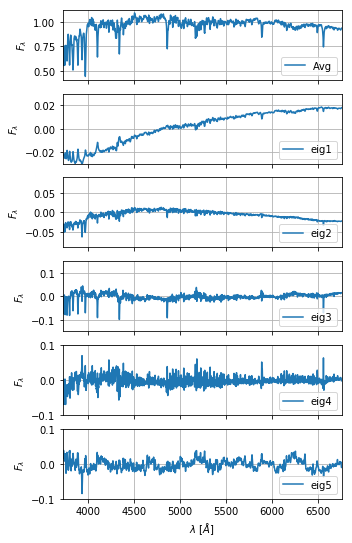

In [29]:
figsize(5,9)
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, sharex=True)
ax1.plot(atlagspektrum[:,0],atlagspektrum[:,1],label='Avg')
ax1.grid(True)
ax1.legend(loc=4)
ax1.set_ylabel('$F_{\lambda}$')
ax2.plot(mintapontok,eig5[0,:],label='eig1')
ax2.grid(True)
ax2.legend(loc=4)
ax2.set_ylim(-0.03,0.03)
ax2.set_ylabel('$F_{\lambda}$')
ax3.plot(mintapontok,eig5[1,:],label='eig2')
ax3.grid(True)
ax3.set_ylim(-0.09,0.09)
ax3.legend(loc=4)
ax3.set_ylabel('$F_{\lambda}$')
ax4.plot(mintapontok,eig5[2,:],label='eig3')
ax4.grid(True)
ax4.set_ylim(-0.15,0.15)
ax4.legend(loc=4)
ax4.set_ylabel('$F_{\lambda}$')
ax5.plot(mintapontok,eig5[3,:],label='eig4')
ax5.grid(True)
ax5.set_ylim(-0.1,0.1)
ax5.set_ylabel('$F_{\lambda}$')
ax5.legend(loc=4)
ax6.plot(mintapontok,eig5[4,:],label='eig5')
ax6.grid(True)
ax6.set_ylim(-0.1,0.1)
ax6.set_ylabel('$F_{\lambda}$')
ax6.legend(loc=4)
xlabel('$\lambda$ [$\AA$]')
xlim(3722,6761)
savefig('eigekkicsi.pdf', bbox_inches='tight')
#pp = PdfPages('eigek.pdf')
#pp.savefig(f, bbox_inches='tight')
#pp.close()

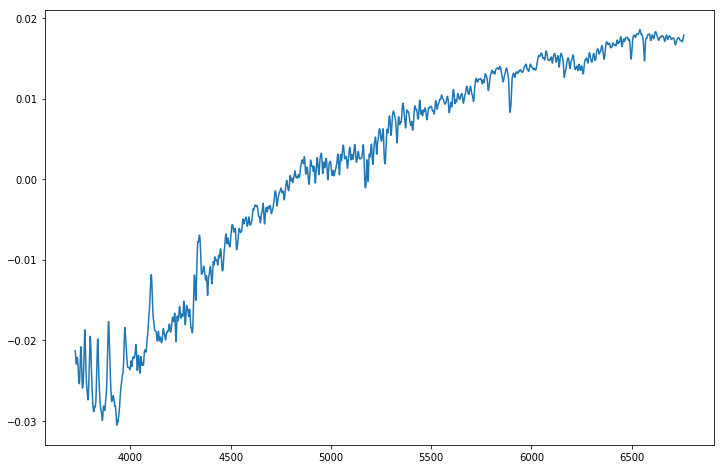

In [22]:
plot(mintapontok,eig5[0,:])

Végül kiszámoljuk a főkomponenseket

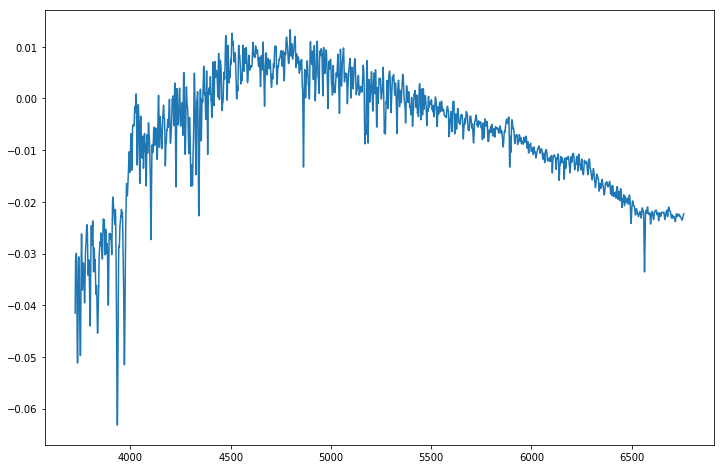

In [23]:
plot(mintapontok,eig5[1,:])

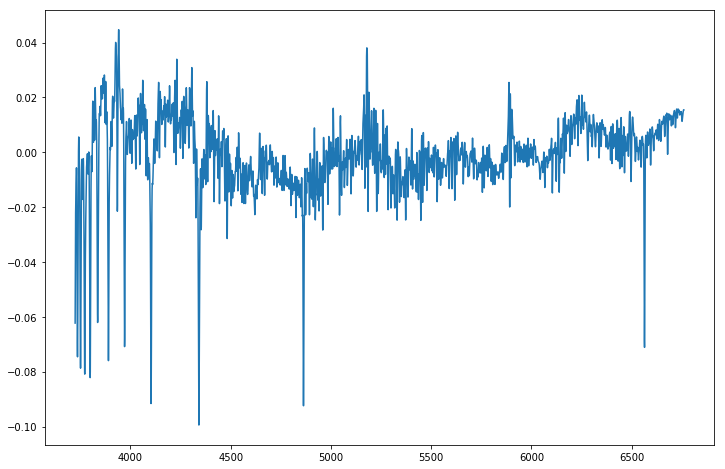

In [24]:
plot(mintapontok,eig5[2,:])

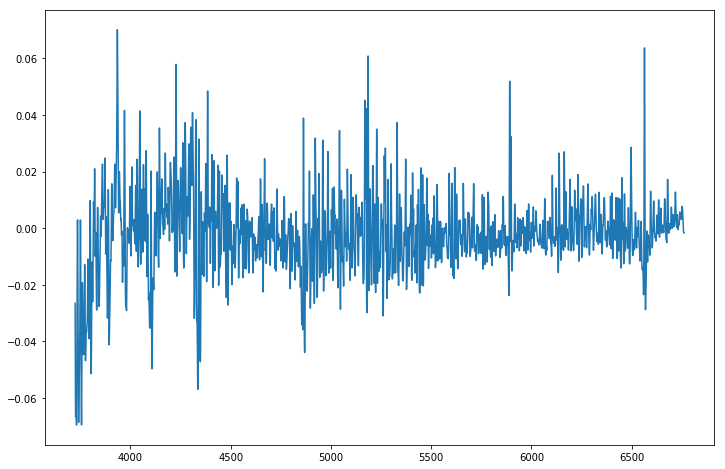

In [25]:
plot(mintapontok,eig5[3,:])

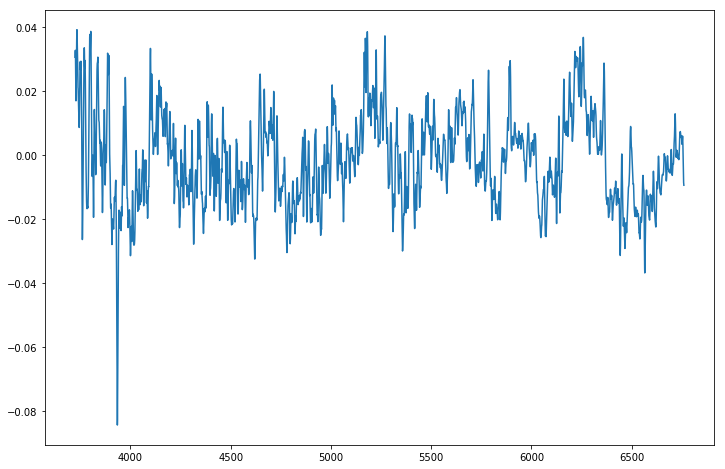

In [26]:
plot(mintapontok,eig5[4,:])

In [27]:
print(eig5)

[[-0.02130956 -0.02135303 -0.02149363 ...,  0.01782163  0.01786838
   0.01790226]
 [-0.04153346 -0.03831928 -0.03518498 ..., -0.02240255 -0.02233769
  -0.02229741]
 [-0.06228547 -0.05143308 -0.03968755 ...,  0.0154886   0.01551049
   0.01545965]
 [-0.02653415 -0.03977301 -0.05252701 ..., -0.00148085 -0.00170205
  -0.00168284]
 [ 0.03048031  0.03211657  0.03266015 ..., -0.00865913 -0.00931842
  -0.00952359]]


In [28]:
PCs=numpy.dot(eig5, korrelaciomatrix)
numpy.save('./PCAfeldolgozas/PCs.npy',PCs)
# print(PCs)

In [2]:
PCs=numpy.load('./PCAfeldolgozas/PCs.npy')
PCs=PCs.T

Innen jön a klaszterezés, az egyes sorokra végzi el, a klaszter indexeket veszem ki utána

In [3]:
from sklearn.cluster import KMeans

In [6]:
print(PCs)

[[ -3.13380973  -0.3989089    0.12805532  -0.14087223  -0.11144051]
 [ -7.59014489  -1.800435    -0.38871227   0.22064907  -0.24254127]
 [ 12.01722363   0.34333498  -0.54036624   0.11323224  -0.11219087]
 ..., 
 [ 18.15471346  -2.61802496   0.03777897   0.08239351  -0.61619396]
 [ -0.59259861   1.27076527   0.43329841  -0.37692142  -0.03463735]
 [ -1.69457836   0.39427457   0.97469403   0.3511541    0.34295578]]


In [4]:
kmeans=KMeans(n_clusters=100).fit(PCs)

In [5]:
numpy.save('./PCAfeldolgozas/kmlabels100.npy',kmeans.labels_)